### 用 tf.data 加载图片

In [1]:
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

Init Plugin
Init Graph Optimizer
Init Kernel


#### 下载并检查数据集

In [2]:
import pathlib

data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

228818944/228813984 [==============================] - 13s 0us/step

In [3]:
for item in data_root.iterdir():
  print(item)

/Users/jacky/.keras/datasets/flower_photos/roses
/Users/jacky/.keras/datasets/flower_photos/sunflowers
/Users/jacky/.keras/datasets/flower_photos/daisy
/Users/jacky/.keras/datasets/flower_photos/dandelion
/Users/jacky/.keras/datasets/flower_photos/tulips
/Users/jacky/.keras/datasets/flower_photos/LICENSE.txt


In [4]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [5]:
all_image_paths[:10]

['/Users/jacky/.keras/datasets/flower_photos/dandelion/19961979110_fcd8092388_m.jpg',
 '/Users/jacky/.keras/datasets/flower_photos/tulips/17159349572_c0c51599f7_n.jpg',
 '/Users/jacky/.keras/datasets/flower_photos/sunflowers/5139971615_434ff8ed8b_n.jpg',
 '/Users/jacky/.keras/datasets/flower_photos/tulips/14087439392_969444f56e.jpg',
 '/Users/jacky/.keras/datasets/flower_photos/tulips/112651128_7b5d39a346_m.jpg',
 '/Users/jacky/.keras/datasets/flower_photos/roses/1540738662_7b4152e344_m.jpg',
 '/Users/jacky/.keras/datasets/flower_photos/roses/5180896559_b8cfefc21e.jpg',
 '/Users/jacky/.keras/datasets/flower_photos/tulips/3449794006_8c289840aa.jpg',
 '/Users/jacky/.keras/datasets/flower_photos/roses/4809566219_88f9a1aea3.jpg',
 '/Users/jacky/.keras/datasets/flower_photos/sunflowers/3846717708_ea11383ed8.jpg']

In [6]:
import os
attributions = (data_root/"LICENSE.txt").open(encoding='utf-8').readlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)

In [7]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])

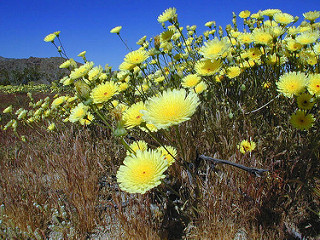

Image (CC BY 2.0)  by Dawn Endico

Image (CC BY 2.0)  by Erik Drost

Image (CC BY 2.0)  by Kain Kalju



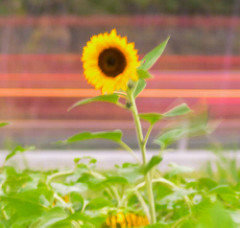

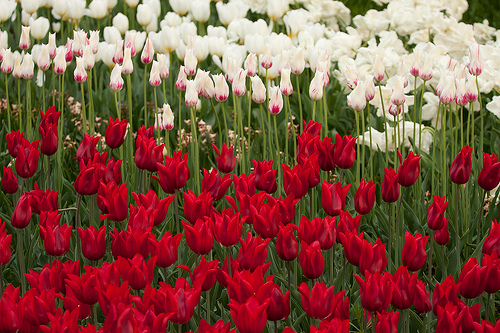

In [8]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print(caption_image(image_path))
  print()

In [12]:
# 确定每张图片的标签

label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [13]:
# 为每个标签分配索引
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [14]:
# 创建一个列表，包含每个文件的标签索引
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])


First 10 labels indices:  [1, 4, 3, 4, 4, 2, 2, 4, 2, 3]


加载和格式化图片

In [15]:
img_path = all_image_paths[0]
img_path

'/Users/jacky/.keras/datasets/flower_photos/dandelion/19961979110_fcd8092388_m.jpg'

In [16]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

Metal device set to: Apple M1
<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00...


2021-08-01 05:59:02.530026: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-08-01 05:59:02.530616: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
# 将它解码为图像 tensor（张量）
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(240, 240, 3)
<dtype: 'uint8'>


In [18]:
# 根据你的模型调整其大小：
img_final = tf.image.resize(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.067156866
0.9664216


In [20]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range

  return image

In [21]:
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

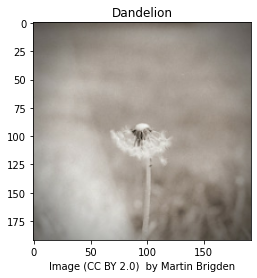

In [22]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path))
plt.title(label_names[label].title())
print()